# Model 1: Logistic Regression

This notebook implements the MDP to generate an optimal policy for the BESS. The notebook is structured as follows:

1) Load data, train-testsplit
2) Finding the optimal solution for the training timeframe using gurobipy 
3) Setup Training Pipeline
4) Hyperparameter Optimisation
5) Train final model on best hyperparameter set
6) Model results on test set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


from gurobipy import GRB, Model, quicksum

**Reading data, train-testsplit**

In [2]:
df_price = pd.read_excel("data/Price.xlsx")
df_price = df_price[df_price["PriceArea"]=="DK2"].drop(
    columns=["HourUTC"]).rename(
        columns={"HourDK":"Hour"}).reset_index(drop=True)
df_price.index = pd.to_datetime(df_price.Hour)
df_price = df_price.drop(columns=["Hour"])      # or: df_price.drop("Hour", axis=1, inplace=True)
df_price.index.name = "Timestamp"

#80-20 train/test
df_train = df_price.iloc[:int(round(0.8*len(df_price),0))].copy()
df_test  = df_price.iloc[int(round(0.8*len(df_price),0)):].copy()

df_train.head()

,PriceArea,PriceDKK,PriceEUR
Timestamp,,,
2021-01-01 00:00:00,DK2,378.519989,50.869999
2021-01-01 01:00:00,DK2,358.579987,48.189999
2021-01-01 02:00:00,DK2,332.459991,44.680000
2021-01-01 03:00:00,DK2,319.369995,42.919998
2021-01-01 04:00:00,DK2,300.540009,40.389999


**Finding the optimal solution for the training timeframe**

In [3]:
Timeframe = len(df_train)        # number of hours
lam = df_train.PriceDKK  # prices
P_max = 100.0      # MW
E_max = 400.0      # MWh

m = Model()

E = m.addVars(Timeframe, lb=0.0, ub=E_max, vtype=GRB.CONTINUOUS, name="E")
a_ch = m.addVars(Timeframe, vtype=GRB.BINARY, name="a_ch")  # charge
a_di = m.addVars(Timeframe, vtype=GRB.BINARY, name="a_di")  # discharge
a_id = m.addVars(Timeframe, vtype=GRB.BINARY, name="a_id")  # idle

m.setObjective(quicksum(lam[t] * P_max * (a_di[t] - a_ch[t]) for t in range(Timeframe)), 
               GRB.MAXIMIZE)

for t in range(Timeframe - 1):
    m.addConstr(E[t+1] == E[t] + P_max * a_ch[t] - P_max * a_di[t])

for t in range(Timeframe):
    m.addConstr( 0 <= E[t])
    m.addConstr(E[t] <= E_max)
    m.addConstr(a_ch[t] + a_di[t] + a_id[t] == 1)

m.addConstr(E[0] == 0.0)
m.optimize()

Set parameter Username
Set parameter LicenseID to value 2625590
Academic license - for non-commercial use only - expires 2026-02-20


/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_27510/297110635.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m.setObjective(quicksum(lam[t] * P_max * (a_di[t] - a_ch[t]) for t in range(Timeframe)),


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 76104 rows, 76104 columns and 171231 nonzeros
Model fingerprint: 0xb7a1fef0
Variable types: 19026 continuous, 57078 integer (57078 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [7e+00, 6e+05]
  Bounds range     [1e+00, 4e+02]
  RHS range        [1e+00, 4e+02]
Found heuristic solution: objective -104185.9985
Presolve removed 38056 rows and 19031 columns
Presolve time: 0.12s
Presolved: 38048 rows, 57073 columns, 114144 nonzeros
Found heuristic solution: objective 104185.99850
Variable types: 0 continuous, 57073 integer (38049 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 3.90s (can be avoided by choosing Method=3)

Solved with primal simplex

Root relaxation: objective 3.

**Making the training dataframes**

In [4]:
X_train = []
y_train = []

for t in range(1, Timeframe):
    soc_t = E[t].X / E_max      # normalized SOC 
    price_prev = lam[t-1]       # λ_{t-1}
    
    X_train.append([soc_t, price_prev])
    if a_ch[t].X >= 0.5:
        y_train.append(1)
    elif a_di[t].X >= 0.5:
        y_train.append(0)
    else:
        y_train.append(np.nan)

X_train = np.array(X_train)
y_train = np.array(y_train, dtype=float)

# ---- remove idle (NaN) rows ----
mask = ~np.isnan(y_train)   # True for charge/discharge rows

X_train = X_train[mask]
y_train = y_train[mask]


/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_27510/2393388144.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_prev = lam[t-1]       # λ_{t-1}


**Visualization of optimal solution**

/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_27510/3594539918.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(time_window[charge_idx], lam_window[charge_idx],
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_27510/3594539918.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(time_window[discharge_idx], lam_window[discharge_idx],
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_27510/3594539918.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent 

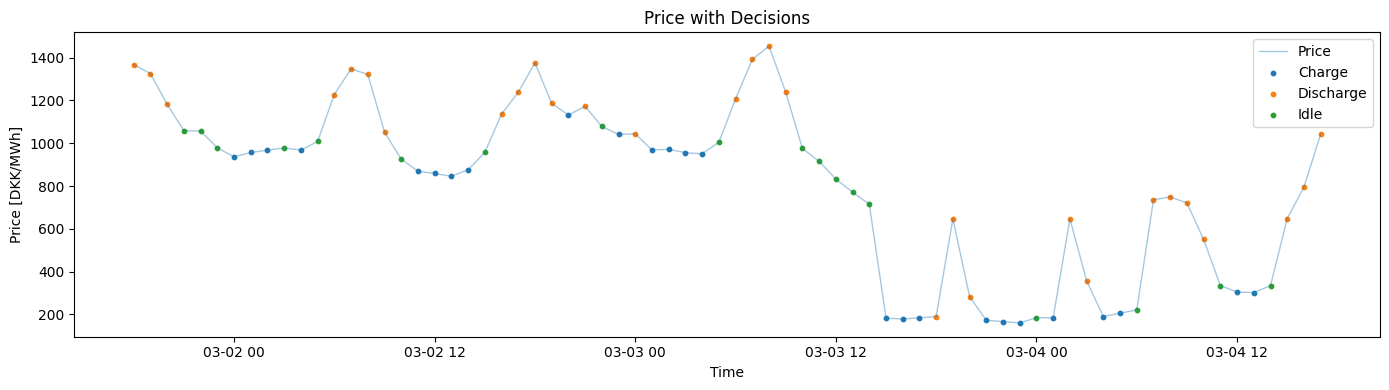

In [5]:
time_axis = df_train.index  

t_start =  len(df_train)-3*24    
t_end   = len(df_train)       

time_window = time_axis[t_start:t_end]
lam_window  = lam[t_start:t_end]

charge_idx = []
discharge_idx = []
idle_idx = []

for t in range(t_start, t_end):
    if a_ch[t].X >= 0.5:
        charge_idx.append(t - t_start)
    elif a_di[t].X >= 0.5:
        discharge_idx.append(t - t_start)
    else:
        idle_idx.append(t - t_start)

charge_idx = np.array(charge_idx)
discharge_idx = np.array(discharge_idx)
idle_idx = np.array(idle_idx)

# --- plot ---
plt.figure(figsize=(14,4))
plt.plot(time_window, lam_window, linewidth=1, alpha=0.4, label="Price")

plt.scatter(time_window[charge_idx], lam_window[charge_idx],
            marker="o", s=10, label="Charge")

plt.scatter(time_window[discharge_idx], lam_window[discharge_idx],
            marker="o", s=10, label="Discharge")

plt.scatter(time_window[idle_idx], lam_window[idle_idx],
            marker="o", s=10, label="Idle")

plt.xlabel("Time")
plt.ylabel("Price [DKK/MWh]")
plt.title("Price with Decisions")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_27510/33815767.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(time_window[charge_idx], lam_window[charge_idx],
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_27510/33815767.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(time_window[discharge_idx], lam_window[discharge_idx],
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_27510/33815767.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

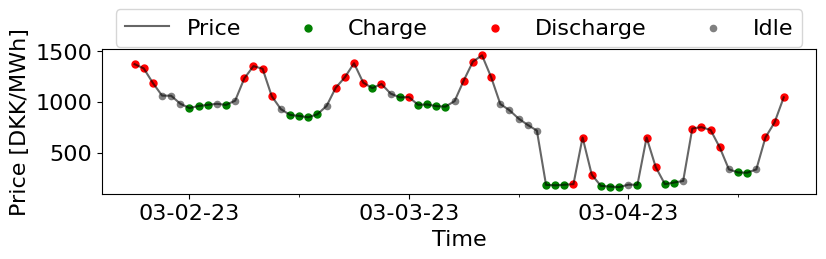

In [6]:
plt.figure(figsize=(8.5, 3))
ax = plt.gca()

import matplotlib.dates as mdates

# --- Format x-axis ticks ---
ax.xaxis.set_major_locator(mdates.DayLocator())           # one tick per day
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))  # format: 03-02, 03-03, ...

ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0, 12]))  # optional minor ticks
ax.tick_params(axis="x", rotation=0)  # Keep readable, or rotation=30 if needed

ax.plot(time_window, lam_window,
        linewidth=1.5, alpha=0.6, label="Price", color="black")

if len(charge_idx) > 0:
    ax.scatter(time_window[charge_idx], lam_window[charge_idx],
               marker="o", s=25, label="Charge", color="green")

if len(discharge_idx) > 0:
    ax.scatter(time_window[discharge_idx], lam_window[discharge_idx],
               marker="o", s=25, label="Discharge", color="red")

if len(idle_idx) > 0:
    ax.scatter(time_window[idle_idx], lam_window[idle_idx],
               marker="o", s=20, label="Idle", color="grey")

ax.set_xlabel("Time", fontsize=16)
ax.set_ylabel("Price [DKK/MWh]", fontsize=16)
#ax.set_title("Price with Storage Decisions", fontsize=16)

ax.tick_params(axis="both", labelsize=16)
ax.legend(fontsize=16, loc="upper right")
ax.grid(False)

ax.legend(
    fontsize=16,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.35),
    ncol=4,
    frameon=True
)

plt.tight_layout()

Pipeline and training with regularizarion

In [7]:
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        penalty=None, #
        max_iter=1000,
        solver="lbfgs"
    )
)

# 2) Time series CV
tscv = TimeSeriesSplit(n_splits=5)

# 3) Grid of regularization parameters C (inverse of regularization strength)
param_grid = {
    #"logisticregression__C": [0.01, 0.1, 1.0, 10.0, 100.0]
}

# 4) GridSearchCV with time-series split
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring="accuracy",   
    n_jobs=-1,            
    refit=True            # refit on full X_train, y_train with best params
)

grid.fit(X_train, y_train)


print("Best CV accuracy:", grid.best_score_)

# 5) Best model (already refit on full training set)
clf = grid.best_estimator_
print("Train accuracy (best model):", clf.score(X_train, y_train))



Best CV accuracy: 0.6542857142857142
Train accuracy (best model): 0.6588655295517651


In [8]:
def choose_action_from_prob(p_charge, P_hat):
    if p_charge > P_hat:
        return "charge"
    elif p_charge < 1.0 - P_hat:
        return "discharge"
    else:
        return "idle"

def simulate_with_classifier(clf, lam, P_hat, P_max, E_max, E0=0.0):
    T = len(lam)
    E = E0 #Here we use E as the current state of the charge
    profit = 0.0

    for t in range(1, T):
        soc_t = E / E_max
        price_prev = lam[t-1]

        x_t = np.array([[soc_t, price_prev]])        # [SOC_t, λ_{t-1}]
        p_charge = clf.predict_proba(x_t)[0, 1]      # P_t(charge | ·)

        action = choose_action_from_prob(p_charge, P_hat)

        # project infeasible actions to idle
        if action == "charge" and E >= E_max:
            action = "idle"
        if action == "discharge" and E <= 0:
            action = "idle"

        price = lam[t]

        if action == "charge":
            dE = min(P_max, E_max - E)
            E += dE
            profit -= price * dE
        elif action == "discharge":
            dE = min(P_max, E)
            E -= dE
            profit += price * dE

    return profit


Cross validation for the threshold parameter P_hat

In [9]:
P_candidates = np.linspace(0.2, 0.6, 20)

lam_train = X_train[:, 1]

cv_scores = {P_hat: [] for P_hat in P_candidates} #Map the test scores

for fold, (train_idx, val_idx) in enumerate(tscv.split(lam_train)):
    lam_val = lam_train[val_idx]  # only validation horizon for this fold

    for P_hat in P_candidates:
        profit = simulate_with_classifier(clf, lam_val, P_hat, P_max, E_max, E0=0.0)
        cv_scores[P_hat].append(profit)

# aggregate profits over folds
avg_profit = {P_hat: np.mean(scores) for P_hat, scores in cv_scores.items()}

best_P = max(avg_profit, key=avg_profit.get)
best_profit = avg_profit[best_P]

print("Cross-validated P_hat:", best_P)
print("Mean CV profit:", best_profit)

Cross-validated P_hat: 0.368421052631579
Mean CV profit: 13605522.505820002


**Optimal solution for the test set**

In [10]:
Timeframe = len(df_test)        
lam = df_test.PriceDKK  
P_max = 100.0      # MW
E_max = 400.0      # MWh

m = Model()

E = m.addVars(Timeframe, lb=0.0, ub=E_max, vtype=GRB.CONTINUOUS, name="E")
a_ch = m.addVars(Timeframe, vtype=GRB.BINARY, name="a_ch")  # charge
a_di = m.addVars(Timeframe, vtype=GRB.BINARY, name="a_di")  # discharge
a_id = m.addVars(Timeframe, vtype=GRB.BINARY, name="a_id")  # idle

m.setObjective(quicksum(lam[t] * P_max * (a_di[t] - a_ch[t]) for t in range(Timeframe)), 
               GRB.MAXIMIZE)

for t in range(Timeframe - 1):
    m.addConstr(E[t+1] == E[t] + P_max * a_ch[t] - P_max * a_di[t])

for t in range(Timeframe):
    m.addConstr( 0 <= E[t])
    m.addConstr(E[t] <= E_max)
    m.addConstr(a_ch[t] + a_di[t] + a_id[t] == 1)

m.addConstr(E[0] == 0.0)
m.optimize()


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 19028 rows, 19028 columns and 42810 nonzeros
Model fingerprint: 0x970b80b8
Variable types: 4757 continuous, 14271 integer (14271 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [7e+00, 4e+05]
  Bounds range     [1e+00, 4e+02]
  RHS range        [1e+00, 4e+02]
Found heuristic solution: objective -19175.99950
Presolve removed 9518 rows and 4762 columns
Presolve time: 0.04s
Presolved: 9510 rows, 14266 columns, 28530 nonzeros
Found heuristic solution: objective 19175.999500
Variable types: 0 continuous, 14266 integer (9511 binary)


/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_27510/90117276.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m.setObjective(quicksum(lam[t] * P_max * (a_di[t] - a_ch[t]) for t in range(Timeframe)),



Root relaxation: objective 5.623223e+07, 2901 iterations, 0.29 seconds (0.45 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                    5.623223e+07 5.6232e+07 -0.00%     -    0s
     0     0 5.6232e+07    0 1660 5.6232e+07 5.6232e+07 -0.00%     -    0s

Explored 1 nodes (2901 simplex iterations) in 0.34 seconds (0.51 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 5.62322e+07 19176 -19176 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.623223483660e+07, best bound 5.623223483660e+07, gap 0.0000%


**Logistics regression predictions**

In [11]:
lam_train = df_test.PriceDKK 
P_hat = best_P

profit = simulate_with_classifier(clf, lam_train, P_hat, P_max, E_max, E0=0.0)
print(f'The cumulative profit is: {round(profit,2) }DKK which captures {round(profit/ m.objVal * 100,2)}% of the optimal value of: {round(m.objVal,2)}DKK')

The cumulative profit is: 5747222.05DKK which captures 10.22% of the optimal value of: 56232234.84DKK


/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_27510/3127155830.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_prev = lam[t-1]
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_27510/3127155830.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price = lam[t]
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_27510/3127155830.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_prev =